<a href="https://colab.research.google.com/github/shreyasrajesh0308/ECE188DeepLearning/blob/main/Adv_example_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [26]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [58]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [57]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [29]:
image_raw = tf.io.read_file('/content/images/rabbit.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

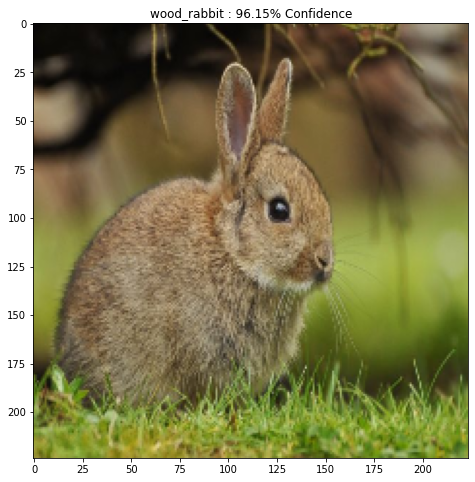

In [30]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [59]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

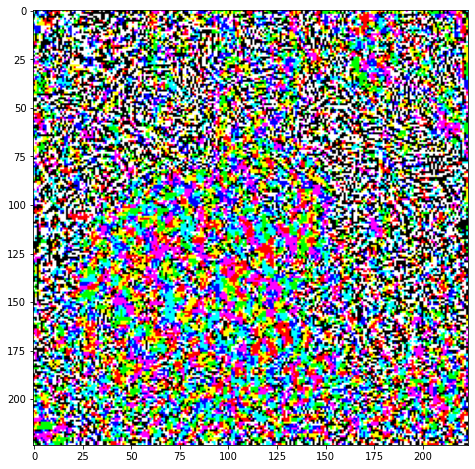

In [32]:
# Get the input label of the image.
wood_rabbit_index = 330
label = tf.one_hot(wood_rabbit_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [33]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

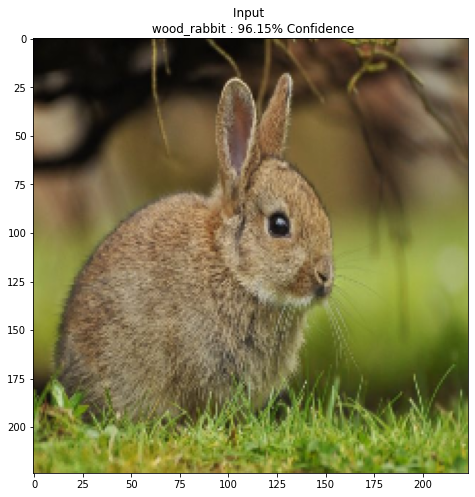

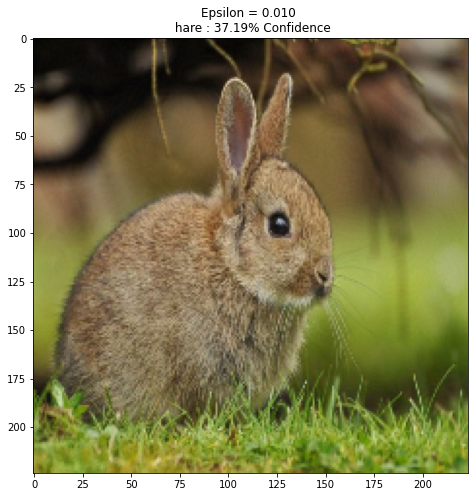

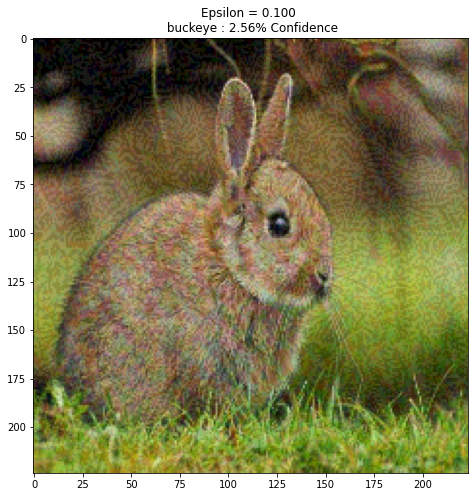

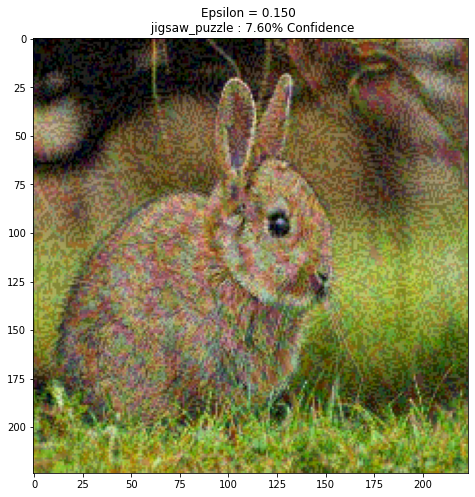

In [34]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [35]:
imagelist=['goldfish','printer','stopwatch','pretzel','pizza','strawberry','European_fire_salamander','revolver','piggy_bank','perfume']
image_indices=[1,742,825,932,963,949,25,763,719,711]

In [60]:
model_eps_val = []
for i in range(0,10):
  image_raw = tf.io.read_file(f'/content/images/img{i+1}.JPEG')
  image = tf.image.decode_image(image_raw)
  image = preprocess(image)

  print("Processing image:", i+1, imagelist[i])

  index = image_indices[i]
  label = tf.one_hot(index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  perturbations = create_adversarial_pattern(image, label)

  prev_val = imagelist[i]
  new_val = prev_val
  eps = 0
  while(new_val == prev_val):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, new_val, _ = get_imagenet_label(pretrained_model.predict(adv_x))
    # display_images(adv_x, 'Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
    # print(new_val, prev_val)
    if new_val == prev_val: # don't update epsilon once attack is successful
      eps = eps + 0.001
  print('\tEnded at epsilon value', eps, "with incorrect label as", new_val)
  model_eps_val.append(eps)

Processing image: 1 goldfish
	Ended at epsilon value 0.004 with incorrect label as puffer
Processing image: 2 printer
	Ended at epsilon value 0.003 with incorrect label as CD_player
Processing image: 3 stopwatch
	Ended at epsilon value 0.08600000000000006 with incorrect label as scale
Processing image: 4 pretzel
	Ended at epsilon value 0.011000000000000003 with incorrect label as bagel
Processing image: 5 pizza
	Ended at epsilon value 0.06600000000000004 with incorrect label as pillow
Processing image: 6 strawberry
	Ended at epsilon value 0.013000000000000005 with incorrect label as purse
Processing image: 7 European_fire_salamander
	Ended at epsilon value 0.21400000000000016 with incorrect label as sea_snake
Processing image: 8 revolver
	Ended at epsilon value 0.003 with incorrect label as violin
Processing image: 9 piggy_bank
	Ended at epsilon value 0.22200000000000017 with incorrect label as teddy
Processing image: 10 perfume
	Ended at epsilon value 0.004 with incorrect label as wat

In [61]:
from pandas import *

In [63]:
mob_net_eps = dict()
eps_vals = dict()
for i in range(len(imagelist)):
  name = imagelist[i]
  val = model_eps_val[i]
  eps_vals[name]=val
mob_net_eps["Epsilon Values"]=eps_vals

print(DataFrame(mob_net_eps))

                          Epsilon Values
European_fire_salamander           0.214
goldfish                           0.004
perfume                            0.004
piggy_bank                         0.222
pizza                              0.066
pretzel                            0.011
printer                            0.003
revolver                           0.003
stopwatch                          0.086
strawberry                         0.013


# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [37]:
models = ["MobileNetV2","ResNet152V2","ResNet101V2","NASNetMobile","NASNetLarge","DenseNet101"]
eps_values = []
eps_values.append(model_eps_val) # append the values form MobileNetV2

# Model 1: ResNetV2 (ResNet152V2)



In [38]:

pretrained_model_resnet = tf.keras.applications.resnet_v2.ResNet152V2(include_top=True,
                                                     weights='imagenet')
pretrained_model_resnet.trainable = False

# ImageNet labels
decode_predictions_resnet = tf.keras.applications.resnet_v2.decode_predictions

242761728/242745792 [==============================] - 1s 0us/step


In [39]:
def preprocess_resnet(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.resnet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions_resnet(probs, top=1)[0][0]

def create_adversarial_pattern_resnet(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model_resnet(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

def get_imagenet_label_resnet(probs):
  return decode_predictions_resnet(probs, top=1)[0][0]

In [40]:
model_eps_val = []
for i in range(0,10):
  image_raw = tf.io.read_file(f'/content/images/img{i+1}.JPEG')
  image = tf.image.decode_image(image_raw)
  image = preprocess_resnet(image)

  print("Processing image:", i+1, imagelist[i])

  index = image_indices[i]
  label = tf.one_hot(index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  perturbations = create_adversarial_pattern_resnet(image, label)

  prev_val = imagelist[i]
  new_val = prev_val
  eps = 0
  while(new_val == prev_val):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, new_val, _ = get_imagenet_label_resnet(pretrained_model_resnet.predict(adv_x))
    # display_images(adv_x, 'Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
    # print(new_val, prev_val)
    if new_val == prev_val: # don't update epsilon once attack is successful
      eps = eps + 0.001
  print('\tEnded at epsilon value', eps, "with incorrect label as", new_val)
  model_eps_val.append(eps)

eps_values.append(model_eps_val)

Processing image: 1 goldfish
	Ended at epsilon value 0.5710000000000004 with incorrect label as starfish
Processing image: 2 printer
	Ended at epsilon value 0.002 with incorrect label as photocopier
Processing image: 3 stopwatch
	Ended at epsilon value 0 with incorrect label as scale
Processing image: 4 pretzel
	Ended at epsilon value 0.5390000000000004 with incorrect label as brain_coral
Processing image: 5 pizza
	Ended at epsilon value 0.005 with incorrect label as jigsaw_puzzle
Processing image: 6 strawberry
	Ended at epsilon value 0.1420000000000001 with incorrect label as trilobite
Processing image: 7 European_fire_salamander
	Ended at epsilon value 0.028000000000000018 with incorrect label as Gila_monster
Processing image: 8 revolver
	Ended at epsilon value 0.003 with incorrect label as rifle
Processing image: 9 piggy_bank
	Ended at epsilon value 0.4210000000000003 with incorrect label as hog
Processing image: 10 perfume
	Ended at epsilon value 0.026000000000000016 with incorrect

# Model 2: ResnetV2 (ResNet101V2)

In [41]:
# tf.keras.applications.resnet_v2.ResNet101V2
pretrained_model_resnetv2 = tf.keras.applications.resnet_v2.ResNet101V2(include_top=True,
                                                     weights='imagenet')
pretrained_model_resnetv2.trainable = False

# ImageNet labels
decode_predictions_resnetv2 = tf.keras.applications.resnet_v2.decode_predictions


179527680/179518384 [==============================] - 1s 0us/step


In [42]:
def preprocess_resnetv2(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.resnet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label_resnetv2(probs):
  return decode_predictions_resnetv2(probs, top=1)[0][0]

def create_adversarial_pattern_resnetv2(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model_resnetv2(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

def get_imagenet_label_resnetv2(probs):
  return decode_predictions_resnetv2(probs, top=1)[0][0]

In [43]:
model_eps_val = []
for i in range(0,10):
  image_raw = tf.io.read_file(f'/content/images/img{i+1}.JPEG')
  image = tf.image.decode_image(image_raw)
  image = preprocess_resnetv2(image)

  print("Processing image:", i+1, imagelist[i])

  index = image_indices[i]
  label = tf.one_hot(index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  perturbations = create_adversarial_pattern_resnetv2(image, label)

  prev_val = imagelist[i]
  new_val = prev_val
  eps = 0
  while(new_val == prev_val):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, new_val, _ = get_imagenet_label_resnetv2(pretrained_model_resnetv2.predict(adv_x))
    # display_images(adv_x, 'Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
    # print(new_val, prev_val)
    if new_val == prev_val: # don't update epsilon once attack is successful
      eps = eps + 0.001
    model_eps_val.append(eps)
  print('\tEnded at epsilon value', eps, "with incorrect label as", new_val)

eps_values.append(model_eps_val)



Processing image: 1 goldfish
	Ended at epsilon value 0.4140000000000003 with incorrect label as loggerhead
Processing image: 2 printer
	Ended at epsilon value 0.003 with incorrect label as photocopier
Processing image: 3 stopwatch
	Ended at epsilon value 0.19300000000000014 with incorrect label as sundial
Processing image: 4 pretzel
	Ended at epsilon value 0.008 with incorrect label as bagel
Processing image: 5 pizza
	Ended at epsilon value 0.006 with incorrect label as pomegranate
Processing image: 6 strawberry
	Ended at epsilon value 0.33900000000000025 with incorrect label as jigsaw_puzzle
Processing image: 7 European_fire_salamander
	Ended at epsilon value 0.02100000000000001 with incorrect label as Gila_monster
Processing image: 8 revolver
	Ended at epsilon value 0.004 with incorrect label as rifle
Processing image: 9 piggy_bank
	Ended at epsilon value 0.21900000000000017 with incorrect label as jigsaw_puzzle
Processing image: 10 perfume
	Ended at epsilon value 0.6240000000000004 

# Model 3: NASNetMobile

In [44]:
pretrained_model_nasnet = tf.keras.applications.nasnet.NASNetMobile(include_top=True,
                                                     weights='imagenet')
pretrained_model_nasnet.trainable = False

# ImageNet labels
decode_predictions_nasnet = tf.keras.applications.nasnet.decode_predictions

24240128/24227760 [==============================] - 0s 0us/step


In [45]:
def preprocess_nasnet(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.nasnet.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label_nasnet(probs):
  return decode_predictions_nasnet(probs, top=1)[0][0]

def create_adversarial_pattern_nasnet(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model_nasnet(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

def get_imagenet_label_nasnet(probs):
  return decode_predictions_nasnet(probs, top=1)[0][0]

In [46]:
model_eps_val = []

for i in range(0,10):
  image_raw = tf.io.read_file(f'/content/images/img{i+1}.JPEG')
  image = tf.image.decode_image(image_raw)
  image = preprocess_nasnet(image)

  print("Processing image:", i+1, imagelist[i])

  index = image_indices[i]
  label = tf.one_hot(index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  perturbations = create_adversarial_pattern_nasnet(image, label)

  prev_val = imagelist[i]
  new_val = prev_val
  eps = 0
  while(new_val == prev_val):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, new_val, _ = get_imagenet_label_nasnet(pretrained_model_nasnet.predict(adv_x))
    # display_images(adv_x, 'Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
    # print(new_val, prev_val)
    if new_val == prev_val: # don't update epsilon once attack is successful
      eps = eps + 0.001
  print('\tEnded at epsilon value', eps, "with incorrect label as", new_val)
  model_eps_val.append(eps)

eps_values.append(model_eps_val)

Processing image: 1 goldfish
	Ended at epsilon value 0.22700000000000017 with incorrect label as axolotl
Processing image: 2 printer
	Ended at epsilon value 0.002 with incorrect label as photocopier
Processing image: 3 stopwatch
	Ended at epsilon value 0 with incorrect label as barometer
Processing image: 4 pretzel
	Ended at epsilon value 0.2990000000000002 with incorrect label as safety_pin
Processing image: 5 pizza
	Ended at epsilon value 0.037000000000000026 with incorrect label as cheeseburger
Processing image: 6 strawberry
	Ended at epsilon value 0.2890000000000002 with incorrect label as purse
Processing image: 7 European_fire_salamander
	Ended at epsilon value 0.33100000000000024 with incorrect label as Gila_monster
Processing image: 8 revolver
	Ended at epsilon value 0.001 with incorrect label as rifle
Processing image: 9 piggy_bank
	Ended at epsilon value 0.4190000000000003 with incorrect label as paper_towel
Processing image: 10 perfume
	Ended at epsilon value 0.003 with inco

# Model 4: NASNetLarge

In [47]:
pretrained_model_nasnet = tf.keras.applications.nasnet.NASNetLarge(include_top=True,
                                                     weights='imagenet')
pretrained_model_nasnet.trainable = False

# ImageNet labels
decode_predictions_nasnet = tf.keras.applications.nasnet.decode_predictions

359759872/359748576 [==============================] - 2s 0us/step


In [48]:
def preprocess_nasnet(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (331, 331))
  image = tf.keras.applications.nasnet.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label_nasnet(probs):
  return decode_predictions_nasnet(probs, top=1)[0][0]

def create_adversarial_pattern_nasnet(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model_nasnet(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

def get_imagenet_label_nasnet(probs):
  return decode_predictions_nasnet(probs, top=1)[0][0]

In [49]:
model_eps_val = []

for i in range(0,10):
  image_raw = tf.io.read_file(f'/content/images/img{i+1}.JPEG')
  image = tf.image.decode_image(image_raw)
  image = preprocess_nasnet(image)

  print("Processing image:", i+1, imagelist[i])

  index = image_indices[i]
  label = tf.one_hot(index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  perturbations = create_adversarial_pattern_nasnet(image, label)

  prev_val = imagelist[i]
  new_val = prev_val
  eps = 0
  while(new_val == prev_val):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, new_val, _ = get_imagenet_label_nasnet(pretrained_model_nasnet.predict(adv_x))
    # display_images(adv_x, 'Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
    # print(new_val, prev_val)
    if new_val == prev_val: # don't update epsilon once attack is successful
      eps = eps + 0.001
  print('\tEnded at epsilon value', eps, "with incorrect label as", new_val)
  model_eps_val.append(eps)

eps_values.append(model_eps_val)

Processing image: 1 goldfish
	Ended at epsilon value 0.5980000000000004 with incorrect label as coho
Processing image: 2 printer
	Ended at epsilon value 0.005 with incorrect label as photocopier
Processing image: 3 stopwatch
	Ended at epsilon value 0.21400000000000016 with incorrect label as barometer
Processing image: 4 pretzel
	Ended at epsilon value 0.45300000000000035 with incorrect label as chain
Processing image: 5 pizza
	Ended at epsilon value 0.32200000000000023 with incorrect label as jigsaw_puzzle
Processing image: 6 strawberry
	Ended at epsilon value 0.3770000000000003 with incorrect label as leatherback_turtle
Processing image: 7 European_fire_salamander
	Ended at epsilon value 0.1360000000000001 with incorrect label as Gila_monster
Processing image: 8 revolver
	Ended at epsilon value 0.32200000000000023 with incorrect label as bobsled
Processing image: 9 piggy_bank
	Ended at epsilon value 0.5940000000000004 with incorrect label as Pembroke
Processing image: 10 perfume
	End

# Model 5: Densenet121

In [50]:
pretrained_model_densenet = tf.keras.applications.densenet.DenseNet121(include_top=True,
                                                     weights='imagenet')
pretrained_model_densenet.trainable = False

# ImageNet labels
decode_predictions_densenet = tf.keras.applications.densenet.decode_predictions

33202176/33188688 [==============================] - 0s 0us/step


In [51]:
def preprocess_densenet(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.densenet.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label_densenet(probs):
  return decode_predictions_densenet(probs, top=1)[0][0]

def create_adversarial_pattern_densenet(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model_densenet(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

def get_imagenet_label_densenet(probs):
  return decode_predictions_densenet(probs, top=1)[0][0]

In [52]:
model_eps_val = []
for i in range(0,10):
  image_raw = tf.io.read_file(f'/content/images/img{i+1}.JPEG')
  image = tf.image.decode_image(image_raw)
  image = preprocess_densenet(image)

  print("Processing image:", i+1, imagelist[i])

  index = image_indices[i]
  label = tf.one_hot(index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  perturbations = create_adversarial_pattern_densenet(image, label)

  prev_val = imagelist[i]
  new_val = prev_val
  eps = 0
  while(new_val == prev_val):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, new_val, _ = get_imagenet_label_densenet(pretrained_model_densenet.predict(adv_x))
    # display_images(adv_x, 'Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
    # print(new_val, prev_val)
    if new_val == prev_val: # don't update epsilon once attack is successful
      eps = eps + 0.001
  print('\tEnded at epsilon value', eps, "with incorrect label as", new_val)
  model_eps_val.append(eps)

eps_values.append(model_eps_val)

Processing image: 1 goldfish
	Ended at epsilon value 0.022000000000000013 with incorrect label as tench
Processing image: 2 printer
	Ended at epsilon value 0.1320000000000001 with incorrect label as studio_couch
Processing image: 3 stopwatch
	Ended at epsilon value 0.007 with incorrect label as barometer
Processing image: 4 pretzel
	Ended at epsilon value 0.06800000000000005 with incorrect label as bagel
Processing image: 5 pizza
	Ended at epsilon value 0.06500000000000004 with incorrect label as wall_clock
Processing image: 6 strawberry
	Ended at epsilon value 0.5810000000000004 with incorrect label as bonnet
Processing image: 7 European_fire_salamander
	Ended at epsilon value 0.20700000000000016 with incorrect label as spotted_salamander
Processing image: 8 revolver
	Ended at epsilon value 0.007 with incorrect label as corkscrew
Processing image: 9 piggy_bank
	Ended at epsilon value 0.5330000000000004 with incorrect label as mask
Processing image: 10 perfume
	Ended at epsilon value 0

### At this point, I have the epsilon values for each image

In [53]:
from pandas import *

In [55]:
print_out = dict()
for i in range(len(eps_values)):
  model_name = models[i]
  image_dict = dict() 
  for j in range(len(imagelist)):
    name = imagelist[j]
    val = eps_values[i][j]
    image_dict[name] = val
  print_out[model_name] = image_dict

print(DataFrame(print_out))

                          MobileNetV2  ResNet152V2  ResNet101V2  NASNetMobile  \
goldfish                        0.004        0.571        0.001         0.227   
printer                         0.003        0.002        0.002         0.002   
stopwatch                       0.086        0.000        0.003         0.000   
pretzel                         0.011        0.539        0.004         0.299   
pizza                           0.066        0.005        0.005         0.037   
strawberry                      0.013        0.142        0.006         0.289   
European_fire_salamander        0.214        0.028        0.007         0.331   
revolver                        0.003        0.003        0.008         0.001   
piggy_bank                      0.222        0.421        0.009         0.419   
perfume                         0.004        0.026        0.010         0.003   

                          NASNetLarge  DenseNet101  
goldfish                        0.598        0.022  
pr

## Analysis
Based on these resutls, we can make some conclusions:

1. ResNet101V2 was one of the easiest models to attack since it wrongly classified an image with low values of epsilon.
2. NASNetLarge was one of the hardest models to attack since it wrongly classified an image with much higher values of epsilon. Even when running the code, this model took significantly more time than the rest.
3. The "stopwatch" image was the easiest to attack.

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 